In [1]:
# All imports
import pandas as pd
import numpy as np
import ast
import json
from collections import defaultdict
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Load data
dataVer10 = "review-Vermont-10.json.gz"
dataVer = "review-Vermont.json.gz"
dataMeta = "meta-Vermont.json.gz"

df_meta = pd.read_json(dataMeta, lines=True, compression="gzip")
df_ver = pd.read_json(dataVer, lines=True, compression="gzip")


In [2]:
# Merge review and metadata dataframes
df = df_ver.merge(df_meta, on="gmap_id", how="left")

# Remove rows with missing text
print("Before removing missing text:", len(df))
df = df.dropna(subset=["text"])
print("After removing missing text:", len(df))

# Remove duplicate reviews (same user reviewing same business)
print("Before removing duplicates:", len(df))
df = df.drop_duplicates(subset=['user_id', 'gmap_id'])
print("After removing duplicates:", len(df))

# Remove unnecessary columns
useless = ["name_x", "name_y", "time", "pics", "resp", "address", "relative_results", "state", "url", "latitude", "longitude"]
maybe = ["description", "num_of_reviews"]
df = df.drop(columns=useless + maybe)

# Remove rows with missing ratings
print("Before removing missing ratings:", len(df))
df = df.dropna(subset=['rating'])
print("After removing missing ratings:", len(df))

# Save preprocessed data
df.to_csv("merged.csv", index=False)
print("Preprocessed data saved to merged.csv")

Before removing missing text: 853549
After removing missing text: 508108
Before removing duplicates: 508108
After removing duplicates: 488212
Before removing missing ratings: 488212
After removing missing ratings: 488052
Preprocessed data saved to merged.csv


In [3]:
# Display sample of preprocessed data
df.head()

,user_id,rating,text,gmap_id,category,avg_rating,price,hours,MISC
0,1.044905e+20,5.0,The Royal Group recently performed standard te...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
2,1.120627e+20,5.0,I can't say enough great things about The Roya...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
4,1.100483e+20,5.0,The Royal Group has done work for us over many...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
6,1.061744e+20,5.0,The Royal Group was fantastic to work with. I ...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
8,1.062387e+20,5.0,"Have used in different houses, installing mult...",0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...


# II. Data Exploration and Visualization

This section provides visualizations and statistical analysis of the dataset to understand the data distribution and relationships between features.


In [4]:
# Load preprocessed data for visualization
df_viz = pd.read_csv("merged.csv")

# Basic statistics
print("Dataset Statistics:")
print(f"Total reviews: {len(df_viz):,}")
print(f"Unique users: {df_viz['user_id'].nunique():,}")
print(f"Unique businesses: {df_viz['gmap_id'].nunique():,}")
print(f"\nRating Statistics:")
print(df_viz['rating'].describe())

# Calculate text length
df_viz['text_length'] = df_viz['text'].astype(str).apply(len)
print(f"\nText Length Statistics:")
print(df_viz['text_length'].describe())


Dataset Statistics:
Total reviews: 488,052
Unique users: 203,213
Unique businesses: 10,992

Rating Statistics:
count    488052.000000
mean          4.326547
std           1.175101
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

Text Length Statistics:
count    488052.000000
mean        158.480943
std         231.423925
min           1.000000
25%          38.000000
50%          83.000000
75%         189.000000
max        6209.000000
Name: text_length, dtype: float64


## A. Rating Distribution


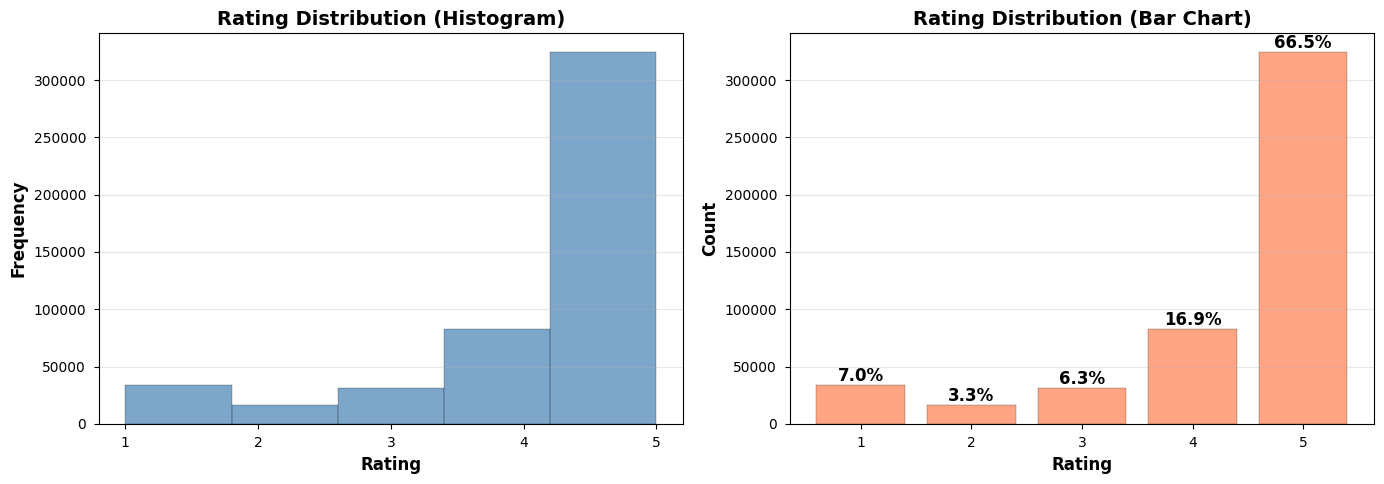


Rating Distribution:
  Rating 1: 34,002 (7.0%)
  Rating 2: 16,118 (3.3%)
  Rating 3: 30,935 (6.3%)
  Rating 4: 82,448 (16.9%)
  Rating 5: 324,549 (66.5%)


In [5]:
# Rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_viz['rating'], bins=5, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Rating', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Rating Distribution (Histogram)', fontweight='bold')
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].grid(axis='y', alpha=0.3)

# Bar plot with percentages
rating_counts = df_viz['rating'].value_counts().sort_index()
rating_pct = (rating_counts / len(df_viz) * 100).round(1)
bars = axes[1].bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Rating', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Rating Distribution (Bar Chart)', fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (idx, val) in enumerate(zip(rating_counts.index, rating_counts.values)):
    axes[1].text(idx, val, f'{rating_pct[idx]:.1f}%', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRating Distribution:")
for rating in sorted(rating_counts.index):
    print(f"  Rating {int(rating)}: {rating_counts[rating]:,} ({rating_pct[rating]:.1f}%)")


## B. Text Length Analysis


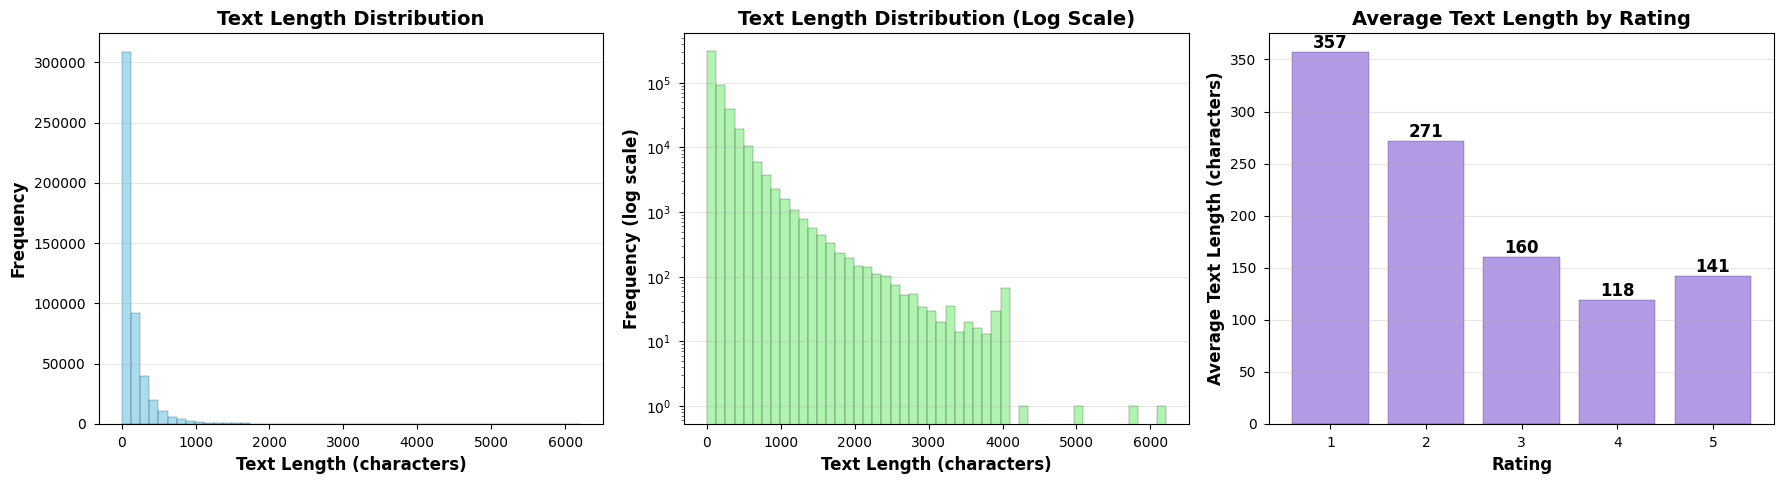


Average Text Length by Rating:
  Rating 1: 357.2 characters
  Rating 2: 272.0 characters
  Rating 3: 160.6 characters
  Rating 4: 118.9 characters
  Rating 5: 141.9 characters


In [6]:
# Text length distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df_viz['text_length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Text Length (characters)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Text Length Distribution', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Log scale histogram
axes[1].hist(df_viz['text_length'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Text Length (characters)', fontweight='bold')
axes[1].set_ylabel('Frequency (log scale)', fontweight='bold')
axes[1].set_title('Text Length Distribution (Log Scale)', fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

# Rating vs Text Length
rating_text_length = df_viz.groupby('rating')['text_length'].mean()
bars = axes[2].bar(rating_text_length.index, rating_text_length.values, 
                   edgecolor='black', alpha=0.7, color='mediumpurple')
axes[2].set_xlabel('Rating', fontweight='bold')
axes[2].set_ylabel('Average Text Length (characters)', fontweight='bold')
axes[2].set_title('Average Text Length by Rating', fontweight='bold')
axes[2].set_xticks([1, 2, 3, 4, 5])
axes[2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for idx, val in zip(rating_text_length.index, rating_text_length.values):
    axes[2].text(idx, val, f'{int(val)}', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Text Length by Rating:")
for rating in sorted(rating_text_length.index):
    print(f"  Rating {int(rating)}: {rating_text_length[rating]:.1f} characters")


## C. Correlation Analysis


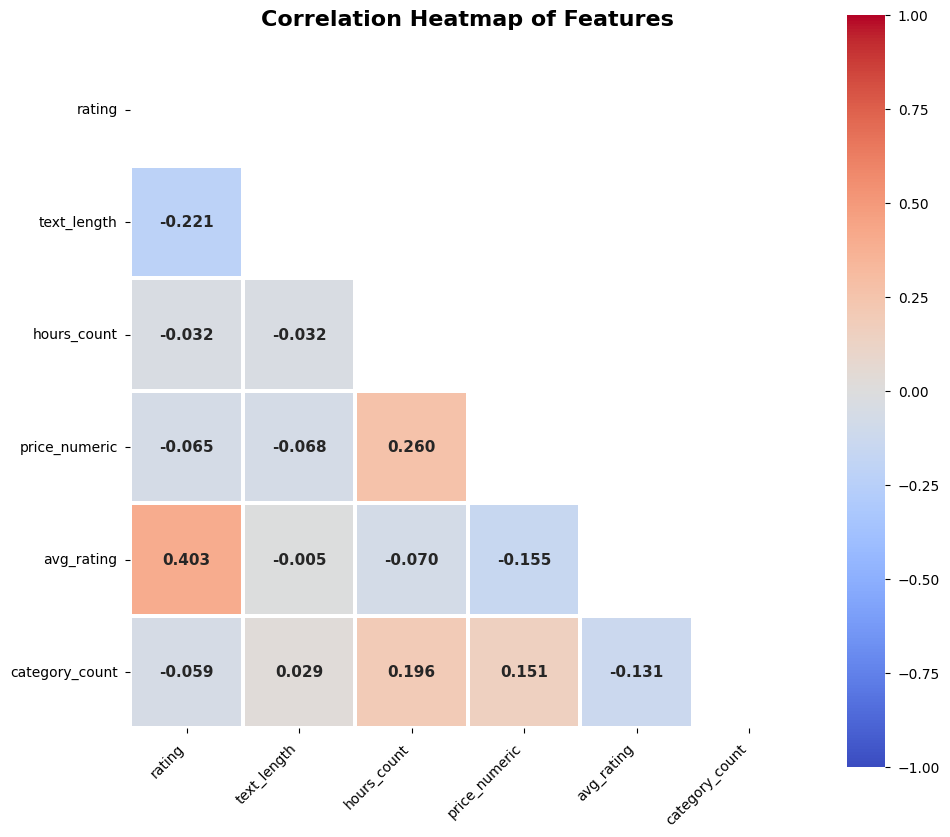


Correlation Matrix:
                rating  text_length  hours_count  price_numeric  avg_rating  \
rating           1.000       -0.221       -0.032         -0.065       0.403   
text_length     -0.221        1.000       -0.032         -0.068      -0.005   
hours_count     -0.032       -0.032        1.000          0.260      -0.070   
price_numeric   -0.065       -0.068        0.260          1.000      -0.155   
avg_rating       0.403       -0.005       -0.070         -0.155       1.000   
category_count  -0.059        0.029        0.196          0.151      -0.131   

                category_count  
rating                  -0.059  
text_length              0.029  
hours_count              0.196  
price_numeric            0.151  
avg_rating              -0.131  
category_count           1.000  

Debug Information:

Avg Rating vs Rating Correlation: 0.4025
Avg Rating Statistics:
count    488052.000000
mean          4.368640
std           0.425831
min           1.000000
25%           4.2

In [7]:
# Prepare features for correlation analysis
df_corr = df_viz.copy()

# Extract hours feature (count of open days)
hours_count = []
for hours_str in df_corr['hours']:
    if pd.isna(hours_str):
        hours_count.append(0)
    else:
        if isinstance(hours_str, str):
            try:
                hours_list = ast.literal_eval(hours_str)
            except:
                hours_list = []
        else:
            hours_list = hours_str
        
        if not isinstance(hours_list, list):
            hours_count.append(0)
        else:
            open_count = 0
            for day_info in hours_list:
                if isinstance(day_info, list) and len(day_info) >= 2:
                    if day_info[1] != 'Closed':
                        open_count += 1
            hours_count.append(open_count)

df_corr['hours_count'] = hours_count
df_corr['text_length'] = df_corr['text'].astype(str).apply(len)

# Extract price as numerical (if available)
if 'price' in df_corr.columns:
    # Convert price to numerical (e.g., '$' -> 1, '$$' -> 2, etc.)
    price_map = {None: 0, np.nan: 0, '$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
    df_corr['price_numeric'] = df_corr['price'].map(price_map).fillna(0)
else:
    df_corr['price_numeric'] = 0

# Extract avg_rating (if available)
# Note: We calculate avg_rating excluding the current review to avoid data leakage
if 'avg_rating' not in df_corr.columns:
    # More efficient way: calculate total and count per business, then subtract current rating
    business_stats = df_corr.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
    business_stats.columns = ['gmap_id', 'total_rating', 'count']
    
    # Merge and calculate avg_rating excluding current review
    df_corr = df_corr.merge(business_stats, on='gmap_id', how='left')
    df_corr['avg_rating'] = (df_corr['total_rating'] - df_corr['rating']) / (df_corr['count'] - 1)
    # Handle cases where count is 1 (only one review for that business)
    df_corr.loc[df_corr['count'] == 1, 'avg_rating'] = df_corr.loc[df_corr['count'] == 1, 'rating']
    df_corr = df_corr.drop(columns=['total_rating', 'count'])

# Extract category count (number of categories per business)
if 'category' in df_corr.columns:
    def count_categories(cat_str):
        if pd.isna(cat_str):
            return 0
        try:
            if isinstance(cat_str, str):
                cat_list = ast.literal_eval(cat_str)
            else:
                cat_list = cat_str
            return len(cat_list) if isinstance(cat_list, list) else 0
        except:
            return 0
    df_corr['category_count'] = df_corr['category'].apply(count_categories)
else:
    df_corr['category_count'] = 0

# Select numerical features for correlation
corr_features = ['rating', 'text_length', 'hours_count', 'price_numeric', 
                 'avg_rating', 'category_count']
df_corr_subset = df_corr[corr_features].dropna()

# Calculate correlation matrix
corr_matrix = df_corr_subset.corr()

# Create correlation heatmap (square format)
n_features = len(corr_matrix)
fig_size = max(10, n_features * 1.2)  # Adjust size based on number of features

plt.figure(figsize=(fig_size, fig_size))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": 0.8}, 
            mask=mask, vmin=-1, vmax=1, 
            annot_kws={'fontsize': max(10, int(14 - n_features * 0.5)), 'fontweight': 'bold'},
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Heatmap of Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# Debug: Check avg_rating correlation with rating
print("\n" + "="*60)
print("Debug Information:")
print("="*60)
if 'avg_rating' in df_corr_subset.columns:
    print(f"\nAvg Rating vs Rating Correlation: {df_corr_subset['avg_rating'].corr(df_corr_subset['rating']):.4f}")
    print(f"Avg Rating Statistics:")
    print(df_corr_subset['avg_rating'].describe())


# III. Modeling

This section describes the models we implement for rating prediction. We start with simple baselines and progressively build more sophisticated models that incorporate text features and metadata.


## A. Baseline Models

We implement two baseline models to establish a performance floor:

1. **Global Mean**: Predicts the average rating across all training examples
2. **Regularized Item Bias (μ + bᵢ)**: Predicts global mean plus a regularized item bias term


In [8]:
# Load data for baseline models
df = pd.read_csv("merged.csv", usecols=['user_id', 'rating', 'gmap_id'])

# Clean and prepare data
df = df.dropna(subset=['user_id', 'rating', 'gmap_id'])
df['rating'] = df['rating'].astype(float)

# Train/Test split
train, test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['rating']
)

print(f"Train size: {len(train)}, Test size: {len(test)}")

# Baseline 1: Global Mean
# Simply predict the average rating across all training examples
global_mean = train['rating'].mean()
print(f"Global Mean: {global_mean:.4f}")

# Make predictions (predict global mean for all test examples)
preds_global = [global_mean] * len(test)

# Evaluate
mse_global = mean_squared_error(test['rating'], preds_global)
# Convert predictions to integers 1-5 for accuracy calculation
preds_global_int = [min(5, max(1, int(round(p)))) for p in preds_global]
acc_global = accuracy_score(test['rating'], preds_global_int)

print(f"Global Mean - MSE: {mse_global:.4f}, Accuracy: {acc_global:.4f}")

# Baseline 2: Regularized Item Bias (μ + bᵢ)
# Predict global mean plus a regularized item bias
# Formula: r̂ᵢⱼ = μ + bᵢ, where bᵢ = (Σ(rᵢⱼ - μ)) / (nᵢ + λ)
# nᵢ is the number of ratings for item i, λ is regularization parameter
global_mean = train['rating'].mean()
lambda_reg = 25  # Regularization parameter

# Compute regularized item biases more efficiently
item_stats = train.groupby('gmap_id').agg({
    'rating': ['sum', 'count']
}).reset_index()
item_stats.columns = ['gmap_id', 'rating_sum', 'n_i']

# Calculate bias: bᵢ = (Σ(rᵢⱼ - μ)) / (nᵢ + λ) = (Σrᵢⱼ - nᵢ*μ) / (nᵢ + λ)
item_stats['bias'] = (item_stats['rating_sum'] - item_stats['n_i'] * global_mean) / (item_stats['n_i'] + lambda_reg)
item_bias_dict = dict(zip(item_stats['gmap_id'], item_stats['bias']))

# Make predictions: r̂ = μ + bᵢ
preds_reg_item = []
for gmap_id in test['gmap_id']:
    if gmap_id in item_bias_dict:
        pred = global_mean + item_bias_dict[gmap_id]
    else:
        # For unseen items, use global mean (bias = 0)
        pred = global_mean
    preds_reg_item.append(pred)

# Evaluate
mse_reg_item = mean_squared_error(test['rating'], preds_reg_item)
preds_reg_item_int = [min(5, max(1, int(round(p)))) for p in preds_reg_item]
acc_reg_item = accuracy_score(test['rating'], preds_reg_item_int)

print(f"Regularized Item Bias (λ={lambda_reg}) - MSE: {mse_reg_item:.4f}, Accuracy: {acc_reg_item:.4f}")


Train size: 390441, Test size: 97611
Global Mean: 4.3265
Global Mean - MSE: 1.3808, Accuracy: 0.1689
Regularized Item Bias (λ=25) - MSE: 1.2103, Accuracy: 0.3948


In [9]:
# Analysis: Why not User Mean?
# Check the distribution of reviews per user
user_review_counts = train.groupby('user_id').size()
single_review_users = (user_review_counts == 1).sum()

print(f"Total unique users in train: {len(user_review_counts)}")
print(f"Users with only 1 review: {single_review_users} ({100*single_review_users/len(user_review_counts):.2f}%)")
print(f"Users with 2+ reviews: {len(user_review_counts) - single_review_users} ({100*(len(user_review_counts)-single_review_users)/len(user_review_counts):.2f}%)")
print("\nSince most users have only 1 review, user mean would not be informative.")


Total unique users in train: 174161
Users with only 1 review: 121350 (69.68%)
Users with 2+ reviews: 52811 (30.32%)

Since most users have only 1 review, user mean would not be informative.


## B. Text-based Linear Model (Main Model #1)

**Intuition**: The sentiment and expressions in text are most directly connected to ratings. Words, phrases, and sentiment expressions contained in review text provide key information for predicting the ratings assigned by users.

We use:
- **TF-IDF vectorization** to convert text into numerical features
- **Ridge Regression** for regularization and to handle the high-dimensional feature space


In [10]:
# Load and prepare data for text-based model
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['rating'], test_size=0.2, random_state=42, stratify=df['rating']
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# TF-IDF Vectorization
# Convert text into numerical features using TF-IDF
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in fewer than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

# Ridge Regression
model_text = Ridge(alpha=1.0)
model_text.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_text = model_text.predict(X_test_tfidf)
y_pred_text_int = np.clip(np.round(y_pred_text), 1, 5)

# Evaluate
mse_text = mean_squared_error(y_test, y_pred_text)
acc_text = accuracy_score(y_test, y_pred_text_int)

print(f"Text-based Model (Ridge) - MSE: {mse_text:.4f}, Accuracy: {acc_text:.4f}")


Train size: 390440, Test size: 97610
TF-IDF feature shape: (390440, 50000)
Vocabulary size: 50000
Text-based Model (Ridge) - MSE: 0.4724, Accuracy: 0.6481


## C. Text + Metadata Model

This model combines text features with metadata to capture both semantic content and contextual information about the business.

**Features**:
- **TF-IDF(text)**: Text vectorization
- **hours**: Operating hours features (count of open hours per week)

We use **Ridge Regression** for this model.


In [11]:
# Load data with metadata
df = pd.read_csv("merged.csv", usecols=['text', 'rating', 'gmap_id', 'hours'])

# Clean and prepare data
df = df.dropna(subset=['text', 'rating', 'gmap_id'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# Train/Test split
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['rating']
)

print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")

# Feature 1: TF-IDF (text)
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_test_tfidf = tfidf.transform(df_test['text'])
print(f"TF-IDF shape: {X_train_tfidf.shape}")

# Feature 2: hours (count of open hours per week)
# Parse hours data and count how many days per week the business is open
hours_count_train = []
for hours_str in df_train['hours']:
    if pd.isna(hours_str):
        hours_count_train.append(0)
    else:
        # Parse the hours string into a list
        if isinstance(hours_str, str):
            hours_list = ast.literal_eval(hours_str)
        else:
            hours_list = hours_str
        
        # Count days that are not "Closed"
        if not isinstance(hours_list, list):
            hours_count_train.append(0)
        else:
            open_count = 0
            for day_info in hours_list:
                if isinstance(day_info, list) and len(day_info) >= 2:
                    if day_info[1] != 'Closed':
                        open_count += 1
            hours_count_train.append(open_count)

hours_count_test = []
for hours_str in df_test['hours']:
    if pd.isna(hours_str):
        hours_count_test.append(0)
    else:
        if isinstance(hours_str, str):
            hours_list = ast.literal_eval(hours_str)
        else:
            hours_list = hours_str
        
        if not isinstance(hours_list, list):
            hours_count_test.append(0)
        else:
            open_count = 0
            for day_info in hours_list:
                if isinstance(day_info, list) and len(day_info) >= 2:
                    if day_info[1] != 'Closed':
                        open_count += 1
            hours_count_test.append(open_count)

print(f"Hours count - Train mean: {np.mean(hours_count_train):.2f}, Test mean: {np.mean(hours_count_test):.2f}")

# Combine features: TF-IDF (sparse) + hours (dense)
# Convert hours to a column vector
hours_train = np.array(hours_count_train).reshape(-1, 1)
hours_test = np.array(hours_count_test).reshape(-1, 1)

X_train_combined = hstack([X_train_tfidf, hours_train])
X_test_combined = hstack([X_test_tfidf, hours_test])
print(f"Combined feature shape - Train: {X_train_combined.shape}, Test: {X_test_combined.shape}")

# Model 1: Ridge Regression
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_combined, df_train['rating'])

y_pred_ridge = model_ridge.predict(X_test_combined)
y_pred_ridge_int = np.clip(np.round(y_pred_ridge), 1, 5)

mse_ridge = mean_squared_error(df_test['rating'], y_pred_ridge)
acc_ridge = accuracy_score(df_test['rating'], y_pred_ridge_int)

print(f"Text + Metadata Model (Ridge) - MSE: {mse_ridge:.4f}, Accuracy: {acc_ridge:.4f}")


Train size: 390440, Test size: 97610
TF-IDF shape: (390440, 50000)
Hours count - Train mean: 5.26, Test mean: 5.25
Combined feature shape - Train: (390440, 50001), Test: (97610, 50001)
Text + Metadata Model (Ridge) - MSE: 0.4723, Accuracy: 0.6480


## D. BERT Embedding Model

**Explanation**: BERT (Bidirectional Encoder Representations from Transformers) provides richer semantic representation of text compared to TF-IDF. It captures contextual word meanings and can better understand the sentiment and nuances in review text.

We use **SBERT (Sentence-BERT)** to generate sentence embeddings, which are then fed into a Linear Regression model.


In [12]:
# Import sentence_transformers (only needed for BERT model)
from sentence_transformers import SentenceTransformer

# Load SBERT model
print("Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Use a subset for efficiency (BERT is computationally expensive)
sample_size = min(50000, len(df_train))
sample_idx = np.random.choice(len(df_train), sample_size, replace=False)

print(f"Generating embeddings for {sample_size} training samples...")
X_train_bert = sbert_model.encode(
    df_train['text'].iloc[sample_idx].tolist(),
    show_progress_bar=True,
    batch_size=32
)
y_train_bert = df_train['rating'].iloc[sample_idx].values

print(f"Generating embeddings for test set...")
X_test_bert = sbert_model.encode(
    df_test['text'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

# Linear Regression on BERT embeddings
model_bert = LinearRegression()
model_bert.fit(X_train_bert, y_train_bert)

# Make predictions
y_pred_bert = model_bert.predict(X_test_bert)
y_pred_bert_int = np.clip(np.round(y_pred_bert), 1, 5)

# Evaluate
mse_bert = mean_squared_error(df_test['rating'], y_pred_bert)
acc_bert = accuracy_score(df_test['rating'], y_pred_bert_int)

print(f"BERT Embedding Model - MSE: {mse_bert:.4f}, Accuracy: {acc_bert:.4f}")
bert_available = True


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading SBERT model...
Generating embeddings for 50000 training samples...


Batches: 100%|██████████| 1563/1563 [01:32<00:00, 16.81it/s]


Generating embeddings for test set...


Batches: 100%|██████████| 3051/3051 [03:04<00:00, 16.54it/s]


BERT Embedding Model - MSE: 0.6404, Accuracy: 0.5735


## E. Model Comparison

Below is a comprehensive comparison of all models we implemented:


In [13]:
# Create comparison table
results = {
    'Model': [
        'Global Mean (Baseline)',
        'Regularized Item Bias (Baseline)',
        'SBERT Embedding',
        'Text-based (TF-IDF + Ridge)',
        'Text + Metadata (Ridge)',
    ],
    'MSE': [
        mse_global,
        mse_reg_item,
        mse_bert,
        mse_text,
        mse_ridge,
    ],
    'Accuracy': [
        acc_global,
        acc_reg_item,
        acc_bert,
        acc_text,
        acc_ridge,
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('MSE')

print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

comparison_df


MODEL COMPARISON
                           Model      MSE  Accuracy
         Text + Metadata (Ridge) 0.472337  0.647997
     Text-based (TF-IDF + Ridge) 0.472352  0.648079
                 SBERT Embedding 0.640420  0.573527
Regularized Item Bias (Baseline) 1.210268  0.394812
          Global Mean (Baseline) 1.380830  0.168936


,Model,MSE,Accuracy
4,Text + Metadata (Ridge),0.472337,0.647997
3,Text-based (TF-IDF + Ridge),0.472352,0.648079
2,SBERT Embedding,0.640420,0.573527
1,Regularized Item Bias (Baseline),1.210268,0.394812
0,Global Mean (Baseline),1.380830,0.168936


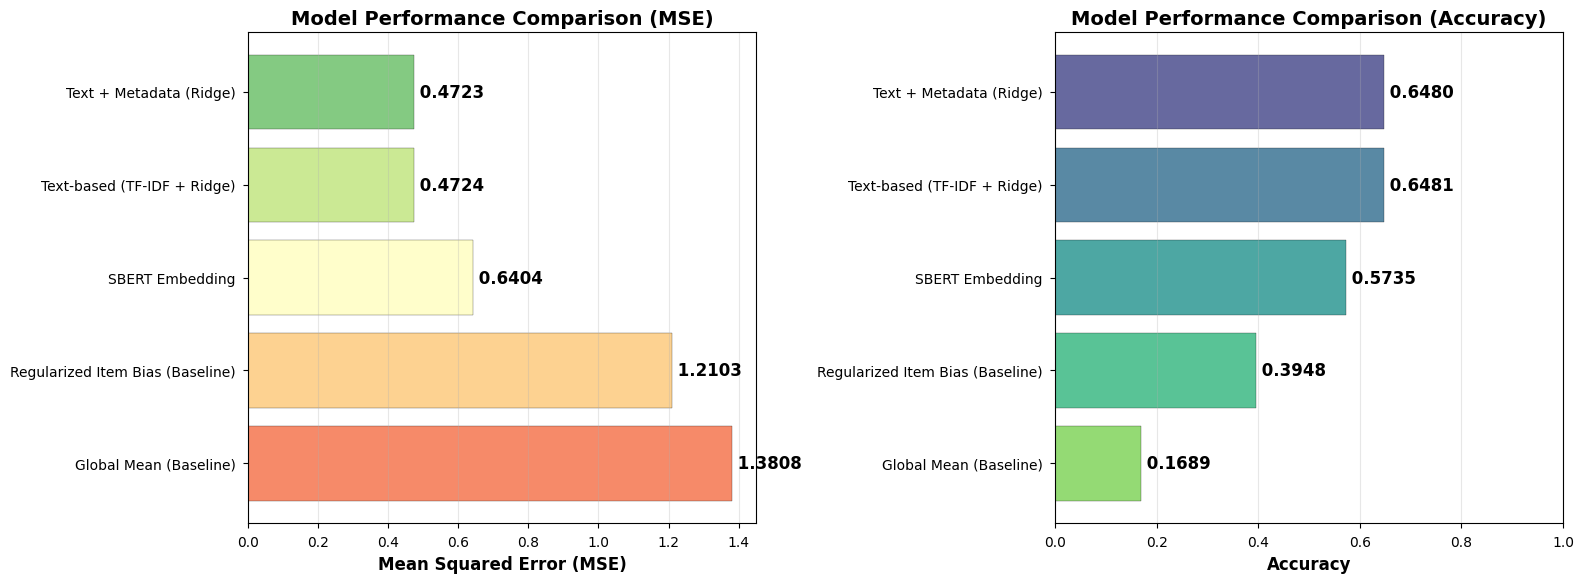

In [14]:
# Model Performance Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by MSE for better visualization
comparison_sorted = comparison_df.sort_values('MSE')

# Bar plot for MSE
colors_mse = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(comparison_sorted)))
bars1 = axes[0].barh(comparison_sorted['Model'], comparison_sorted['MSE'], 
                      color=colors_mse, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Mean Squared Error (MSE)', fontweight='bold', fontsize=12)
axes[0].set_title('Model Performance Comparison (MSE)', fontweight='bold', fontsize=14)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()  # Best model on top

# Add value labels
for i, (idx, val) in enumerate(zip(comparison_sorted.index, comparison_sorted['MSE'])):
    axes[0].text(val, i, f' {val:.4f}', va='center', fontweight='bold')

# Bar plot for Accuracy
colors_acc = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_sorted)))
bars2 = axes[1].barh(comparison_sorted['Model'], comparison_sorted['Accuracy'], 
                      color=colors_acc, edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Accuracy', fontweight='bold', fontsize=12)
axes[1].set_title('Model Performance Comparison (Accuracy)', fontweight='bold', fontsize=14)
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()  # Best model on top
axes[1].set_xlim([0, 1])

# Add value labels
for i, (idx, val) in enumerate(zip(comparison_sorted.index, comparison_sorted['Accuracy'])):
    axes[1].text(val, i, f' {val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


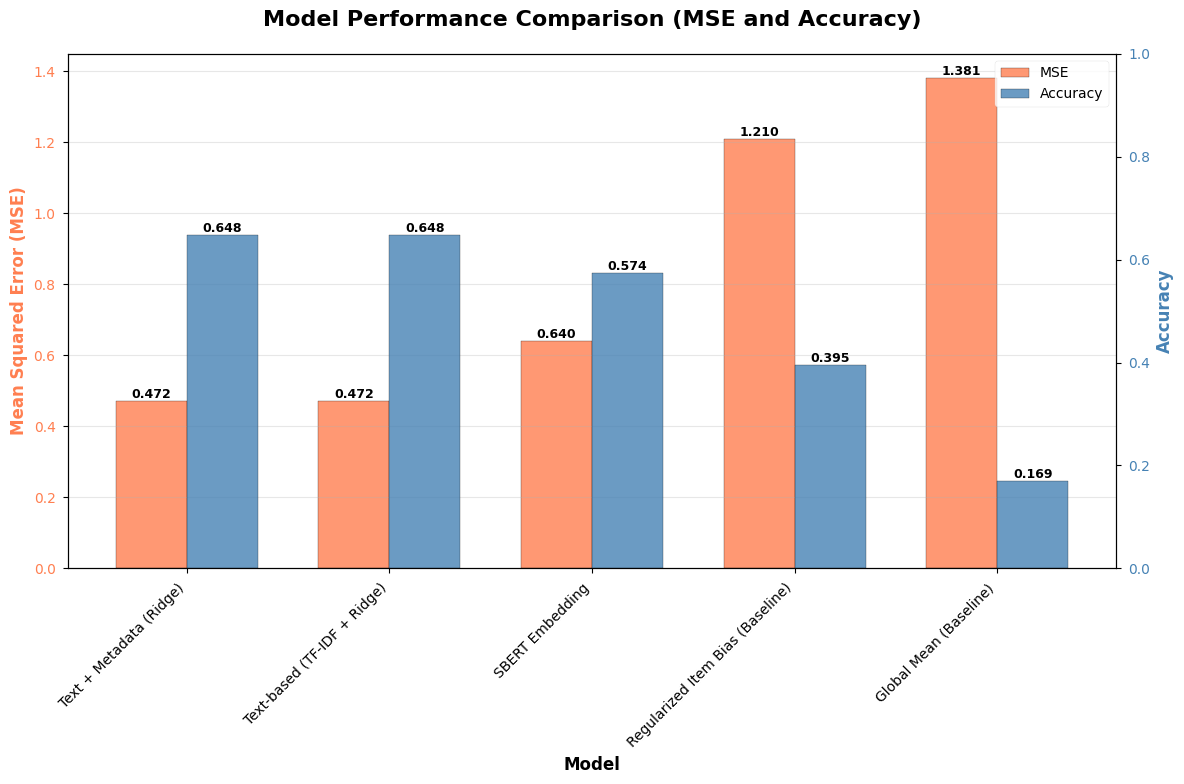

In [15]:
# Combined performance plot (MSE and Accuracy)
fig, ax1 = plt.subplots(figsize=(12, 8))

x = np.arange(len(comparison_sorted))
width = 0.35

# Create bars
bars1 = ax1.bar(x - width/2, comparison_sorted['MSE'], width, 
                label='MSE', color='coral', edgecolor='black', alpha=0.8)
ax1.set_xlabel('Model', fontweight='bold', fontsize=12)
ax1.set_ylabel('Mean Squared Error (MSE)', fontweight='bold', fontsize=12, color='coral')
ax1.tick_params(axis='y', labelcolor='coral')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_sorted['Model'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Second y-axis for Accuracy
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, comparison_sorted['Accuracy'], width,
                label='Accuracy', color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=12, color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2.set_ylim([0, 1])

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/2., height1,
             f'{height1:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax2.text(bar2.get_x() + bar2.get_width()/2., height2,
             f'{height2:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_title('Model Performance Comparison (MSE and Accuracy)', 
              fontweight='bold', fontsize=16, pad=20)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('model_performance_combined.png', dpi=300, bbox_inches='tight')
plt.show()
